In [7]:
pip install tensorflow keras matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math

Data Generators

In [2]:
# Parameters
img_height, img_width = 128, 128  # Adjust based on your dataset
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Validation and Test Data (No Augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    'divided_images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'divided_images/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'divided_images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 3683 images belonging to 47 classes.
Found 1033 images belonging to 47 classes.
Found 564 images belonging to 47 classes.


Building the CNN Model

In [3]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(47, activation='softmax')  # 47 classes for Kannada alphabets
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


E:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │          12,079 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,528,111 (24.90 MB)

 Trainable params: 6,528,111 (24.90 MB)

 Non-trainable params: 0 (0.00 B)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the extended CNN model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),  # Normalize activations to stabilize learning
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block (added)
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),  # Increased to 512 units
    Dropout(0.5),  # Regularization to reduce overfitting
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(47, activation='softmax')  # 47 classes for Kannada alphabets
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Training the Model

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('D:/blob_canny_1.keras', monitor='val_accuracy', save_best_only=True)
# steps_per_epoch = train_generator.samples // batch_size
# validation_steps = validation_generator.samples // batch_size

steps_per_epoch = math.ceil(train_generator.samples / batch_size)
validation_steps = math.ceil(validation_generator.samples / batch_size)

# Training
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=300,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



Epoch 1/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 61s 229ms/step - accuracy: 0.7840 - loss: 0.7101 - val_accuracy: 0.8421 - val_loss: 0.5577 - learning_rate: 2.0000e-04
Epoch 2/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 3/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - accuracy: 0.7987 - loss: 0.6837 - val_accuracy: 0.8488 - val_loss: 0.5652 - learning_rate: 2.0000e-04
Epoch 4/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 5/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 58s 222ms/step - accuracy: 0.7995 - loss: 0.6753 - val_accuracy: 0.8440 - val_loss: 0.5695 - learning_rate: 2.0000e-04
Epoch 6/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 7/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - accuracy: 0.7989 - loss: 0.6779 - val_accuracy: 0.8343 - val_loss: 0.5704 - learning_rat

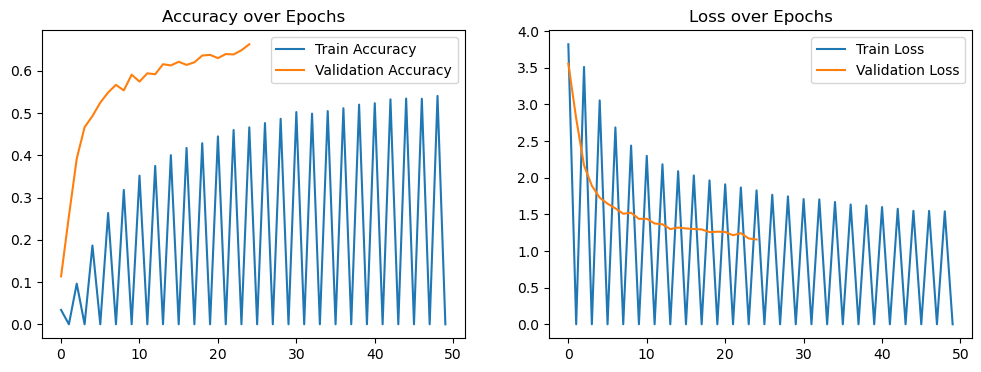

In [94]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


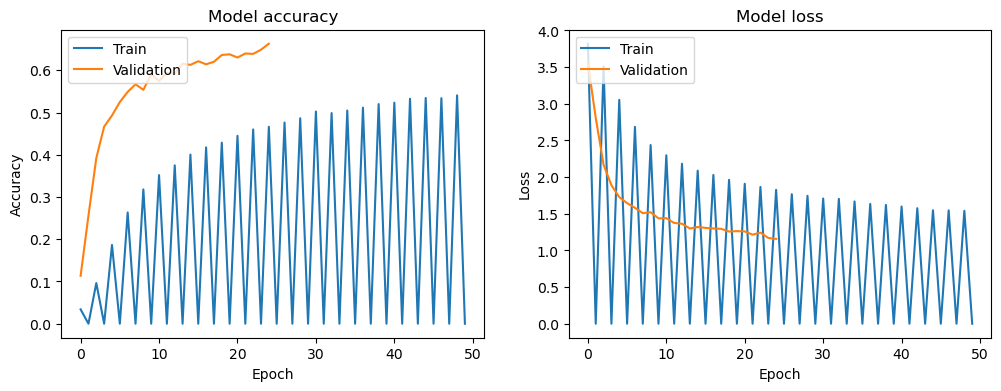

In [95]:
import matplotlib.pyplot as plt

# Assuming history is your fit result
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [5]:
from tensorflow.keras.models import load_model

best_model = load_model('best_cnn_model_new.keras')


In [20]:
# Load the best model
# model.load_weights('best_cnn_model_new.keras')
model.load_weights('blob_canny.keras')

# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7773 - loss: 0.7354
Test Accuracy: 80.27%


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.67      0.73        12
          10       0.57      0.73      0.64        11
          11       1.00      0.75      0.86        12
          12       0.46      0.50      0.48        12
          13       0.73      0.92      0.81        12
          14       0.41      0.82      0.55        11
          15       1.00      0.75      0.86        12
          16       0.92      0.92      0.92        12
          17       0.67      0.33      0.44        12
          18       0.67      0.91      0.77        11
          19       0.75      1.00      0.86        12
           2       0.77      0.91      0.83        11
          20       0.78      0.58      0.67        12
          21       0.90      0.75      0.82        12
          22       0.83      0.83      0.83        12
          23       1.00      0.75      0.86        12
          24      

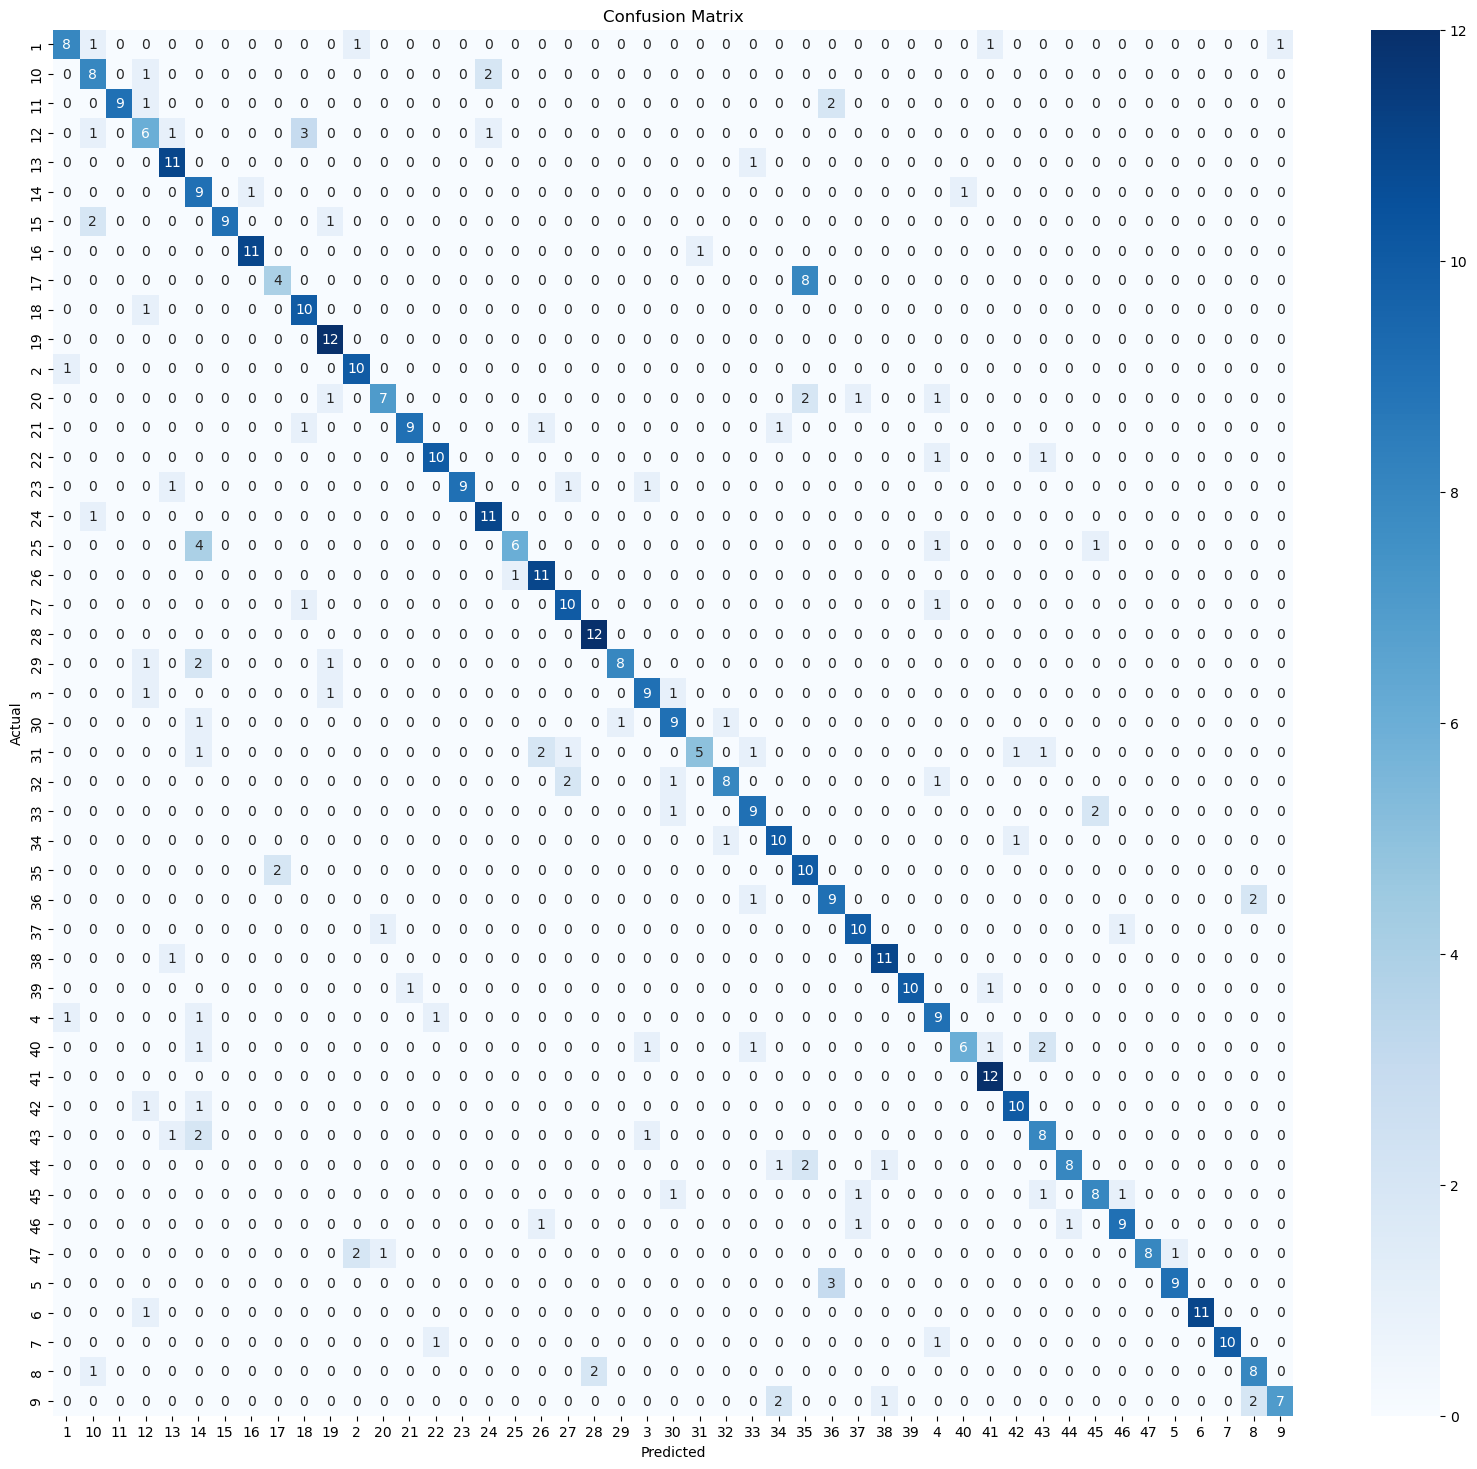

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure test_generator has shuffle=False
test_generator.reset()

# Predict probabilities for all test images
# Convert steps to int to avoid TypeError
steps = int(np.ceil(test_generator.samples / batch_size))
predictions = model.predict(test_generator, steps=steps)

# Convert probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Mapping from class indices to class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(20, 18))  # Adjust size based on number of classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Model Tuning

In [40]:
pip install keras-tuner


  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ------------ -------------------------- 41.0/129.1 kB 245.8 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 328.2 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 302.7 kB/s eta 0:00:01
   --------------------------- ----------- 92.2/129.1 kB 327.7 k

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    
    # First Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(128, 128, 3)  # Update if different
    ))
    model.add(layers.MaxPooling2D((2,2)))
    
    # Additional Conv Layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2,2)))
    
    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(layers.Dense(47, activation='softmax'))  # 49 classes for Kannada alphabets
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [4]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='kannada_alphabet_tuning'
)


E:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[stop_early]
)


Trial 6 Complete [00h 05m 58s]

Best val_accuracy So Far: 0.5314617455005646
Total elapsed time: 01h 38m 48s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
64                |32                |filters_1
3                 |1                 |num_conv_layers
96                |128               |filters_2
512               |384               |dense_units
0.4               |0.5               |dropout
0.01              |0.0001            |learning_rate
128               |None              |filters_3
64                |None              |filters_4



In [54]:
# Load the best model
tuner.results_summary(num_trials=1)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


NameError: name 'tuner' is not defined

In [13]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

kannada_mapping = {
    0: 'ಅ', 1: 'ಆ', 2: 'ಇ', 3: 'ಈ', 4: 'ಉ',
    5: 'ಊ', 6: 'ಋ', 7: 'ಎ', 8: 'ಏ', 9: 'ಐ',
    10: 'ಒ', 11: 'ಓ', 12: 'ಔ', 13: 'ಕ', 14: 'ಖ',
    15: 'ಗ', 16: 'ಘ', 17: 'ಙ', 18: 'ಚ', 19: 'ಛ',
    20: 'ಜ', 21: 'ಝ', 22: 'ಞ', 23: 'ಟ', 24: 'ಠ',
    25: 'ಡ', 26: 'ಢ', 27: 'ಣ', 28: 'ತ', 29: 'ಥ',
    30: 'ದ', 31: 'ಧ', 32: 'ನ', 33: 'ಪ', 34: 'ಫ',
    35: 'ಬ', 36: 'ಭ', 37: 'ಮ', 38: 'ಯ', 39: 'ರ',
    40: 'ಲ', 41: 'ವ', 42: 'ಶ', 43: 'ಷ', 44: 'ಸ',
    45: 'ಹ', 46: 'ಳ'
}

# Load the trained model
# model = load_model('best_cnn_model.keras')
model=load_model('D:/model/partial_broken_2.keras')
# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict function
def predict_alphabet(image_path, class_indices):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]

# Example usage
# image_path = 'canny_edges/test/jha_2_contrast_enhance.png'
image_path = 'new_test/test/IMG_20241208_095903.jpg'
predicted_alphabet = predict_alphabet(image_path, test_generator.class_indices)
b=int(predicted_alphabet)-1
ann=kannada_mapping[b]
# image_path = 'new_test/rru_contrast_enhance.png'
# predicted_alphabet = predict_alphabet(image_path, test_generator.class_indices)
print(f'Predicted Alphabet: {ann}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted Alphabet: ಇ


Fine tuning

In [16]:
from tensorflow.keras.models import load_model

model = load_model('D:/model/partial_broken_2.keras')


In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [18]:
new_train_generator = train_datagen.flow_from_directory(
    'D:/blob(cnn)/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

new_validation_generator = validation_datagen.flow_from_directory(
    'd:/blob(cnn)/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 18225 images belonging to 47 classes.
Found 5120 images belonging to 47 classes.


In [21]:
steps_per_epoch = math.ceil(new_train_generator.samples / batch_size)
validation_steps = math.ceil(new_validation_generator.samples / batch_size)

history = model.fit(
    new_train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Adjust as needed
    validation_data=new_validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4690 - loss: 1.9169

E:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


570/570 ━━━━━━━━━━━━━━━━━━━━ 825s 1s/step - accuracy: 0.4690 - loss: 1.9168 - val_accuracy: 0.5922 - val_loss: 1.4298 - learning_rate: 0.0010
Epoch 2/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50


E:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
E:\Anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
E:\Anaconda\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
E:\Anaconda\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None,

570/570 ━━━━━━━━━━━━━━━━━━━━ 263s 461ms/step - accuracy: 0.5031 - loss: 1.7311 - val_accuracy: 0.6025 - val_loss: 1.3999 - learning_rate: 0.0010
Epoch 4/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 333s 481ms/step - accuracy: 0.5211 - loss: 1.6527 - val_accuracy: 0.6084 - val_loss: 1.3451 - learning_rate: 0.0010
Epoch 6/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 106us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 282s 494ms/step - accuracy: 0.5271 - loss: 1.6247 - val_accuracy: 0.6180 - val_loss: 1.3104 - learning_rate: 0.0010
Epoch 8/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50
570/570 ━━━━━━━━━━━━━━━━━━━━ 284s 497ms/step - accuracy: 0.5450 - loss: 1.5695 - val_accuracy: 0.5957 - val_loss: 1.3751 - learning_rate: 0.0010
Epoch 10/50
570/570 ━━━━━━━━━

In [23]:
model.save('D:/model/partial_broken_3.keras')


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('D:/partial_broken_3.keras', monitor='val_accuracy', save_best_only=True)

In [35]:
model.load_weights('D:/model/partial_broken_2.keras')

# Evaluate on Test Data
test_loss, test_acc = model.evaluate(new_test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.8245 - loss: 0.5524
Test Accuracy: 84.19%


In [33]:
new_test_generator = test_datagen.flow_from_directory(
    'D:/divided_images_2/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2162 images belonging to 47 classes.


In [6]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

kannada_mapping = {
    0: 'ಅ', 1: 'ಆ', 2: 'ಇ', 3: 'ಈ', 4: 'ಉ',
    5: 'ಊ', 6: 'ಋ', 7: 'ಎ', 8: 'ಏ', 9: 'ಐ',
    10: 'ಒ', 11: 'ಓ', 12: 'ಔ', 13: 'ಕ', 14: 'ಖ',
    15: 'ಗ', 16: 'ಘ', 17: 'ಙ', 18: 'ಚ', 19: 'ಛ',
    20: 'ಜ', 21: 'ಝ', 22: 'ಞ', 23: 'ಟ', 24: 'ಠ',
    25: 'ಡ', 26: 'ಢ', 27: 'ಣ', 28: 'ತ', 29: 'ಥ',
    30: 'ದ', 31: 'ಧ', 32: 'ನ', 33: 'ಪ', 34: 'ಫ',
    35: 'ಬ', 36: 'ಭ', 37: 'ಮ', 38: 'ಯ', 39: 'ರ',
    40: 'ಲ', 41: 'ವ', 42: 'ಶ', 43: 'ಷ', 44: 'ಸ',
    45: 'ಹ', 46: 'ಳ'
}

# Load the trained model
# model = load_model('best_cnn_model.keras')
model=load_model('D:/model/partial_broken_3.keras')
# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict function
def predict_alphabet(image_path, class_indices):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]

# Example usage
# image_path = 'canny_edges/test/jha_2_contrast_enhance.png'
image_path = 'D:/img.jpg'
predicted_alphabet = predict_alphabet(image_path, test_generator.class_indices)
b=int(predicted_alphabet)-1
ann=kannada_mapping[b]
# image_path = 'new_test/rru_contrast_enhance.png'
# predicted_alphabet = predict_alphabet(image_path, test_generator.class_indices)
print(f'Predicted Alphabet: {ann}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Alphabet: ಆ


In [6]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Define Kannada character mapping
kannada_mapping = {
    0: 'ಅ', 1: 'ಆ', 2: 'ಇ', 3: 'ಈ', 4: 'ಉ',
    5: 'ಊ', 6: 'ಋ', 7: 'ಎ', 8: 'ಏ', 9: 'ಐ',
    10: 'ಒ', 11: 'ಓ', 12: 'ಔ', 13: 'ಕ', 14: 'ಖ',
    15: 'ಗ', 16: 'ಘ', 17: 'ಙ', 18: 'ಚ', 19: 'ಛ',
    20: 'ಜ', 21: 'ಝ', 22: 'ಞ', 23: 'ಟ', 24: 'ಠ',
    25: 'ಡ', 26: 'ಢ', 27: 'ಣ', 28: 'ತ', 29: 'ಥ',
    30: 'ದ', 31: 'ಧ', 32: 'ನ', 33: 'ಪ', 34: 'ಫ',
    35: 'ಬ', 36: 'ಭ', 37: 'ಮ', 38: 'ಯ', 39: 'ರ',
    40: 'ಲ', 41: 'ವ', 42: 'ಶ', 43: 'ಷ', 44: 'ಸ',
    45: 'ಹ', 46: 'ಳ'
}

# Load the trained model
model_path = 'D:/updated_model.keras'  # Use relative path
model = load_model(model_path)

# Image preprocessing
img_width, img_height = 128, 128  # Input size for the model

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Grayscale if input expects 1 channel
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    return img

# Predict function
def predict_alphabet(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    return kannada_mapping[class_idx]

# Example usage
image_path = 'D:/img.jpg'  # Use relative path
try:
    predicted_alphabet = predict_alphabet(preprocess_image(image_path)
    print(f'Predicted Alphabet: {predicted_alphabet}')
except FileNotFoundError:
    print(f"Image not found: {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: Can't convert object to 'str' for 'filename'


In [3]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read as a color image (default is BGR)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [8]:
import os
import cv2

def resize_images_in_folder(input_folder, output_folder, target_size=(128, 128)):
    """
    Resize all images in the subfolders of a folder to the specified target size.

    Args:
        input_folder (str): Path to the input folder containing subfolders with images.
        output_folder (str): Path to the folder where resized images will be saved.
        target_size (tuple): Target dimensions (width, height) for resizing images.
    """
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Walk through all subfolders in the input folder
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Construct full input path
                input_image_path = os.path.join(root, file)
                
                # Handle Unicode filenames by normalizing paths
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                
                # Ensure the subfolder exists in the output folder
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)
                
                # Construct full output path
                output_image_path = os.path.join(output_subfolder, file)

                try:
                    # Read the image
                    image = cv2.imread(input_image_path)
                    if image is None:
                        print(f"Failed to load: {input_image_path}")
                        continue

                    # Resize the image
                    resized_image = cv2.resize(image, target_size)

                    # Save the resized image
                    cv2.imwrite(output_image_path, resized_image)
                    print(f"Resized and saved: {output_image_path}")
                except Exception as e:
                    print(f"Error processing {input_image_path}: {e}")



# Example usage
input_folder = 'D:/Damaged letters/Damaged letters'  # Replace with the path to your input folder
output_folder = 'D:/Damaged letters/1'  # Replace with the path to your output folder

resize_images_in_folder(input_folder, output_folder)


Resized and saved: D:/Damaged letters/1\1\IMG_20241208_095606.jpg
Resized and saved: D:/Damaged letters/1\1\IMG_20241208_114429.jpg
Resized and saved: D:/Damaged letters/1\10\IMG_20241208_104931.jpg
Resized and saved: D:/Damaged letters/1\10\IMG_20241208_174529.jpg
Resized and saved: D:/Damaged letters/1\14\IMG_20241208_095831.jpg
Resized and saved: D:/Damaged letters/1\14\IMG_20241208_174957.jpg
Resized and saved: D:/Damaged letters/1\15\IMG_20241208_095903.jpg
Resized and saved: D:/Damaged letters/1\15\IMG_20241208_175059.jpg
Resized and saved: D:/Damaged letters/1\17\IMG_20241208_095927.jpg
Resized and saved: D:/Damaged letters/1\17\IMG_20241208_175231.jpg
Resized and saved: D:/Damaged letters/1\18\IMG_20241208_095954.jpg
Resized and saved: D:/Damaged letters/1\18\IMG_20241208_181406.jpg
Resized and saved: D:/Damaged letters/1\2\IMG_20241208_095652.jpg
Resized and saved: D:/Damaged letters/1\2\IMG_20241208_125654.jpg
Resized and saved: D:/Damaged letters/1\3\IMG_20241208_095711.jpg


In [12]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import cv2

kannada_mapping = {
    0: 'ಅ', 1: 'ಆ', 2: 'ಇ', 3: 'ಈ', 4: 'ಉ',
    5: 'ಊ', 6: 'ಋ', 7: 'ಎ', 8: 'ಏ', 9: 'ಐ',
    10: 'ಒ', 11: 'ಓ', 12: 'ಔ', 13: 'ಕ', 14: 'ಖ',
    15: 'ಗ', 16: 'ಘ', 17: 'ಙ', 18: 'ಚ', 19: 'ಛ',
    20: 'ಜ', 21: 'ಝ', 22: 'ಞ', 23: 'ಟ', 24: 'ಠ',
    25: 'ಡ', 26: 'ಢ', 27: 'ಣ', 28: 'ತ', 29: 'ಥ',
    30: 'ದ', 31: 'ಧ', 32: 'ನ', 33: 'ಪ', 34: 'ಫ',
    35: 'ಬ', 36: 'ಭ', 37: 'ಮ', 38: 'ಯ', 39: 'ರ',
    40: 'ಲ', 41: 'ವ', 42: 'ಶ', 43: 'ಷ', 44: 'ಸ',
    45: 'ಹ', 46: 'ಳ'
}

# Load the trained model
model = load_model('D:/partial_broken_3.keras')

# Image dimensions
img_width, img_height = 128, 128

# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict function
def predict_alphabet(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    return class_idx

# Process a folder of images
def classify_images_in_folder(folder_path, output_file='classification_results.txt'):
    results = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                class_idx = predict_alphabet(image_path)
                kannada_alphabet = kannada_mapping.get(class_idx, "Unknown")
                results.append(f"{image_path}: {kannada_alphabet}")

    # Save results to a file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("\n".join(results))
    
    print(f"Classification results saved to {output_file}")

# Example usage
input_folder = 'D:/Damaged letters/2'
classify_images_in_folder(input_folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [11]:
import os
import cv2
from PIL import Image, ImageEnhance
import numpy as np

def process_images_in_folder(input_folder, output_folder, target_size=(128, 128), contrast_factor=1.5):
    """
    Resize images to target size, convert to grayscale, and enhance contrast.

    Args:
        input_folder (str): Path to the input folder containing subfolders with images.
        output_folder (str): Path to the folder where processed images will be saved.
        target_size (tuple): Target dimensions (width, height) for resizing images.
        contrast_factor (float): Factor by which to enhance the contrast.
    """
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Walk through all subfolders in the input folder
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Construct full input path
                input_image_path = os.path.join(root, file)

                # Handle Unicode filenames by normalizing paths
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)

                # Ensure the subfolder exists in the output folder
                if not os.path.exists(output_subfolder):
                    os.makedirs(output_subfolder)

                # Construct full output path
                output_image_path = os.path.join(output_subfolder, file)

                try:
                    # Step 1: Load image
                    image = Image.open(input_image_path)

                    # Step 2: Resize image
                    image = image.resize(target_size, Image.Resampling.LANCZOS)

                    # Step 3: Convert to grayscale
                    grayscale_image = image.convert("L")

                    # Step 4: Enhance contrast
                    enhancer = ImageEnhance.Contrast(grayscale_image)
                    enhanced_image = enhancer.enhance(contrast_factor)

                    # Step 5: Save processed image
                    enhanced_image.save(output_image_path)
                    print(f"Processed and saved: {output_image_path}")

                except Exception as e:
                    print(f"Error processing {input_image_path}: {e}")

# Example usage
input_folder = 'D:/Damaged letters/1'  # Replace with the path to your input folder
output_folder = 'D:/Damaged letters/2'  # Replace with the path to your output folder

process_images_in_folder(input_folder, output_folder)


Processed and saved: D:/Damaged letters/2\1\1.jpg
Processed and saved: D:/Damaged letters/2\1\2.jpg
Processed and saved: D:/Damaged letters/2\1\IMG_20241208_095606.jpg
Processed and saved: D:/Damaged letters/2\1\IMG_20241208_114429.jpg
Processed and saved: D:/Damaged letters/2\10\IMG_20241208_104931.jpg
Processed and saved: D:/Damaged letters/2\10\IMG_20241208_174529.jpg
Processed and saved: D:/Damaged letters/2\14\IMG_20241208_095831.jpg
Processed and saved: D:/Damaged letters/2\14\IMG_20241208_174957.jpg
Processed and saved: D:/Damaged letters/2\15\IMG_20241208_095903.jpg
Processed and saved: D:/Damaged letters/2\15\IMG_20241208_175059.jpg
Processed and saved: D:/Damaged letters/2\17\IMG_20241208_095927.jpg
Processed and saved: D:/Damaged letters/2\17\IMG_20241208_175231.jpg
Processed and saved: D:/Damaged letters/2\18\IMG_20241208_095954.jpg
Processed and saved: D:/Damaged letters/2\18\IMG_20241208_181406.jpg
Processed and saved: D:/Damaged letters/2\2\1.jpg
Processed and saved: D:/